In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy


from qcal.modelconstruction.single_qubit_models import *
from qcal.modelconstruction.experiment_design import *

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

In [26]:
class ExperimentDesign:
    def __init__(self, 
                    germs : List[Tuple[str]], 
                    inphase_state_preps :List[Tuple[str]], 
                    quadruature_state_preps :List[Tuple[str]], 
                    meas_fiducials : List[Tuple[str]], 
                    depths : List[int],
                    line_labels : List[str],
                    ):
        """Initialize the experiment design.

        The germs, state preps, and mesurements are lists 
        of strings that should all be the same length

        Args:
            germs (List[str]): list of germs.
            inphase_state_preps (List[str]): list of in-phase state preps.
            quadruature_state_preps (List[str]): list of quadrature state preps.
            meas_fiducial (List[str]): list of measurement fiducials.
            depths (List[int]): list of depths.
        """
        # check lengths
        if len(germs) != len(inphase_state_preps) != len(quadruature_state_preps) != len(meas_fiducials):
            raise ValueError("All lists must be the same length.")
        
        self.germs = germs
        self.inphase_state_preps = inphase_state_preps
        self.quadruature_state_preps = quadruature_state_preps
        self.meas_fiducials = meas_fiducials
        self.depths = depths
        self.line_labels = line_labels

        self.circuit_dict = self._construct_edesign()

    def __str__(self) -> str:
        return f"Experiment design with {len(self.germs)} germs, {len(self.depths)} depths, and {self.num_circuits} circuits"
    
    def __getitem__(self, germ) -> Circuit:
        """Get a circuit by key.

        Args:
            key (str): key to the circuit.

        Returns:
            Circuit: circuit.
        """
        if not isinstance(germ, str):
            germ = '.'.join(germ)
        return self.circuit_dict[germ]
    
    def germ_to_hash(self, germ):
        return '.'.join([g[0] for g in germ])
    
    @property
    def num_circuits(self) -> int:
        """Number of circuits in the experiment design.

        Returns:
            int: number of circuits.
        """
        return 2 * len(self.germs) * len(self.depths)
    
    @property
    def circuit_list(self) -> List[Circuit]:
        """List of circuits in the experiment design.

        Returns:
            List[Circuit]: list of circuits.
        """
        all_circs = []
        for germ in self.germs:
            germ_str = self.germ_to_hash(germ)
            for depth in self.depths:
                all_circs.append(self.circuit_dict[germ_str]['I'][depth])
                all_circs.append(self.circuit_dict[germ_str]['Q'][depth])
        return pygsti.remove_duplicates(all_circs)


    def _construct_edesign(self):
        """Construct the experiment design.
        
        The experiment design is a three-level dictionary with 
        keys1 that label the germ
        keys2 that label in-phase or quadrature
        keys3 that label the depth
        The values are pygsti gate sequences. 

        Returns:
            Dict: experiment design.
        """

        edesign = {}
        for idx, germ in enumerate(self.germs):
            # convert the germ tuple to a germ string separated by . 
            germ_str = self.germ_to_hash(germ)
            edesign[germ_str] = {'I': {}, 'Q': {}}
            for depth in self.depths:
                edesign[germ_str]['I'][depth] = Circuit(self.inphase_state_preps[idx] + germ*depth + self.meas_fiducials[idx], line_labels=self.line_labels)
                edesign[germ_str]['Q'][depth] = Circuit(self.quadruature_state_preps[idx] + germ*depth + self.meas_fiducials[idx], line_labels=self.line_labels)
        return edesign
    
    def make_dataset(self, model, num_shots_per_circuit):
        """
        Make a dataset from the experiment design.
        """
        ds = pygsti.data.simulate_data(model, self.circuit_list, num_samples=num_shots_per_circuit)
        return ds
    
    def plot_dataset(self, ds, target_model=None):
        """Make a bunch of subplots for the dataset."""

        for germ in self.germs:
            germ_str = self.germ_to_hash(germ)
            fig, ax = plt.subplots(2, len(self.depths), figsize=(10, 5), sharey=True)
            # set the germ as the super title
            fig.suptitle(germ_str)
            for idx, depth in enumerate(self.depths):
                inphase_circ  = self.circuit_dict[germ_str]['I'][depth]
                quad_circ = self.circuit_dict[germ_str]['Q'][depth]
                inphase_data = ds[inphase_circ].counts
                quad_data = ds[quad_circ].counts
                if target_model is not None:
                    inphase_target_probs = target_model.probabilities(inphase_circ)
                    quad_target_probs = target_model.probabilities(quad_circ)
                    num_counts = sum(inphase_data.values())

                ax[0, idx].bar([0, 1], [inphase_data['0'], inphase_data['1']])
                if target_model is not None:
                    ax[0, idx].bar([0, 1], [inphase_target_probs['0']*num_counts, inphase_target_probs['1']*num_counts], alpha=0.5)
                ax[0, idx].set_title(f'I at {depth}')
                ax[1, idx].bar([0, 1], [quad_data['0'], quad_data['1']])
                if target_model is not None:
                    ax[1, idx].bar([0, 1], [quad_target_probs['0']*num_counts, quad_target_probs['1']*num_counts], alpha=0.5)
                ax[1, idx].set_title(f'Q at {depth}')
            # set share axis

            plt.tight_layout()

In [27]:
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as _Qrpe

In [28]:
def make_1q_xz_germs(qid):
    gxpi2 = [('Gxpi2', qid)]
    gzpi2 = [('Gzpi2', qid)]
    germ1 = gxpi2
    germ2 = gxpi2 + gzpi2 + gzpi2 + gxpi2 + gzpi2 + gzpi2
    germ3 = gxpi2*2 + gzpi2*2
    return [germ1, germ2, germ3]

def make_1q_xz_inphase_preps(qid):
    gxpi2 = [('Gxpi2', qid)]
    gzpi2 = [('Gzpi2', qid)]
    gypi2 = gzpi2 + gxpi2 + gzpi2*3
    return [[], gypi2, []]

def make_1q_xz_quadrature_preps(qid):
    gxpi2 = [('Gxpi2', qid)]
    gzpi2 = [('Gzpi2', qid)]
    gypi2 = gzpi2 + gxpi2 + gzpi2*3
    return [gxpi2, gxpi2, gypi2]

def make_1q_xz_measurment(qid):
    gxpi2 = [('Gxpi2', qid)]
    gzpi2 = [('Gzpi2', qid)]
    gypi2 = gzpi2 + gxpi2 + gzpi2*3
    return [[], gypi2*3, []]

In [29]:
# # define experiment design

# # gate def
# Gypi2 = ['Gzpi2', 'Gxpi2', 'Gzpi2', 'Gzpi2', 'Gzpi2']
# Gxpi2 = ['Gxpi2']

# # germ def
# germ1 = Gxpi2
# germ2 = Gypi2
# germ3 = Gxpi2 + Gxpi2 + Gypi2 + Gypi2 

# # state prep def 
# inphase1 = []
# inphase2 = []
# inphase3 = Gypi2

# quad1 = Gxpi2
# quad2 = Gypi2
# quad3 = Gxpi2

# # meas def
# meas1 = []
# meas2 = []
# meas3 = Gypi2*3

qid = 'Q0'
germs = make_1q_xz_germs(qid)
inphase_state_prep = make_1q_xz_inphase_preps(qid)
quad_state_prep = make_1q_xz_quadrature_preps(qid)
meas = make_1q_xz_measurment(qid)
depths = [2**i for i in range(10)]
line_labels = [qid]
edesign = ExperimentDesign(germs, inphase_state_prep, quad_state_prep, meas, depths, line_labels)

In [30]:
print(edesign)
print(edesign.circuit_dict.keys())

Experiment design with 3 germs, 10 depths, and 60 circuits
dict_keys(['Gxpi2', 'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2', 'Gxpi2.Gxpi2.Gzpi2.Gzpi2'])


In [31]:
for circ in edesign.circuit_list:
    print(circ)

Qubit Q0 ---|Gxpi2|---

Qubit Q0 ---|Gxpi2|-|Gxpi2|---

Qubit Q0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|---

Qubit Q0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---

Qubit Q0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---

Qubit Q0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---

Qubit Q0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---

Qubit Q0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---

Qubit Q0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---

Qubit Q0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---

Qubit Q0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxp

In [32]:
error_vec = np.zeros(3)
zx_model = create_XZ_model_1q(error_vec)
zx_model.sim

In [33]:
ds = pygsti.data.simulate_data(zx_model, edesign.circuit_list, num_samples=1000, seed=2021)
print(ds)

Gxpi2:Q0@(Q0)  :  {('0',): 496.0, ('1',): 504.0}
Gxpi2:Q0Gxpi2:Q0@(Q0)  :  {('0',): 0.0, ('1',): 1000.0}
Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0@(Q0)  :  {('0',): 496.0, ('1',): 504.0}
Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0@(Q0)  :  {('0',): 1000.0, ('1',): 0.0}
Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0@(Q0)  :  {('0',): 516.0, ('1',): 484.0}
Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0@(Q0)  :  {('0',): 1000.0, ('1',): 0.0}
Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0@(Q0)  :  {('0',): 495.0, ('1',): 505.0}
Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0@(Q0)  :  {('0',): 1000.0, ('1',): 0.0}
Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0@(Q0)  :  {('0',): 497.0, ('1',): 503.0}
Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxpi2:Q0Gxp

In [47]:
def estimate_phase(ds, edesign, target_germ, inphase_plus_label, inphase_minus_label, quad_plus_label, quad_minus_label, depths):
    """
    Estimate the phase of germ in a dataset using RPE.
    """   
    if not isinstance(target_germ, str):
        germ_str = edesign.germ_to_hash(target_germ)
    else: 
        germ_str = target_germ
    
    experiment = _Qrpe()
    for idx, d in enumerate(depths):
        inphase_circ = edesign.circuit_dict[germ_str]['I'][d]
        x_cos_counts = ds[inphase_circ].counts
        experiment.process_cos(d, 
                               (int(x_cos_counts[inphase_plus_label]), 
                                int(x_cos_counts[inphase_minus_label]))
        )
        quad_circ_at_d = edesign.circuit_dict[germ_str]['Q'][d]
        x_sin_counts = ds[quad_circ_at_d].counts
        experiment.process_sin(d, 
                               (int(x_sin_counts[quad_plus_label]), 
                                int(x_sin_counts[quad_minus_label]))
        )
        print(d, germ_str, x_cos_counts, x_sin_counts)
    analysis = RobustPhaseEstimation(experiment)
    phase_estimates = analysis.angle_estimates
    last_good_idx = analysis.check_unif_local(historical=True)
    return phase_estimates, last_good_idx

In [48]:
depths

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

In [49]:
error_vec = np.array([0.01, 0.01, 0.01])
zx_model = create_XZ_model_1q(error_vec)
target_model = create_XZ_model_1q(np.array([0, 0, 0]))
edesign = ExperimentDesign(germs, inphase_state_prep, quad_state_prep, meas, depths, line_labels)
ds = pygsti.data.simulate_data(zx_model, edesign.circuit_list, num_samples=1000, seed=2021)

In [50]:
estimate_phase(ds, edesign, 'Gxpi2', '0', '1', '0', '1', depths)

1 Gxpi2 OutcomeLabelDict([(('0',), 499.0), (('1',), 501.0)]) OutcomeLabelDict([(('0',), 0.0), (('1',), 1000.0)])
2 Gxpi2 OutcomeLabelDict([(('0',), 0.0), (('1',), 1000.0)]) OutcomeLabelDict([(('0',), 533.0), (('1',), 467.0)])
4 Gxpi2 OutcomeLabelDict([(('0',), 1000.0), (('1',), 0.0)]) OutcomeLabelDict([(('0',), 459.0), (('1',), 541.0)])
8 Gxpi2 OutcomeLabelDict([(('0',), 998.0), (('1',), 2.0)]) OutcomeLabelDict([(('0',), 446.0), (('1',), 554.0)])
16 Gxpi2 OutcomeLabelDict([(('0',), 997.0), (('1',), 3.0)]) OutcomeLabelDict([(('0',), 401.0), (('1',), 599.0)])
32 Gxpi2 OutcomeLabelDict([(('0',), 973.0), (('1',), 27.0)]) OutcomeLabelDict([(('0',), 340.0), (('1',), 660.0)])
64 Gxpi2 OutcomeLabelDict([(('0',), 904.0), (('1',), 96.0)]) OutcomeLabelDict([(('0',), 190.0), (('1',), 810.0)])
128 Gxpi2 OutcomeLabelDict([(('0',), 636.0), (('1',), 364.0)]) OutcomeLabelDict([(('0',), 23.0), (('1',), 977.0)])
256 Gxpi2 OutcomeLabelDict([(('0',), 83.0), (('1',), 917.0)]) OutcomeLabelDict([(('0',), 241.

(array([4.71038898, 4.67943677, 4.69193474, 4.69888751, 4.70010013,
        4.70219574, 4.70216244, 4.70228702, 4.7022882 , 4.70238861]),
 9)

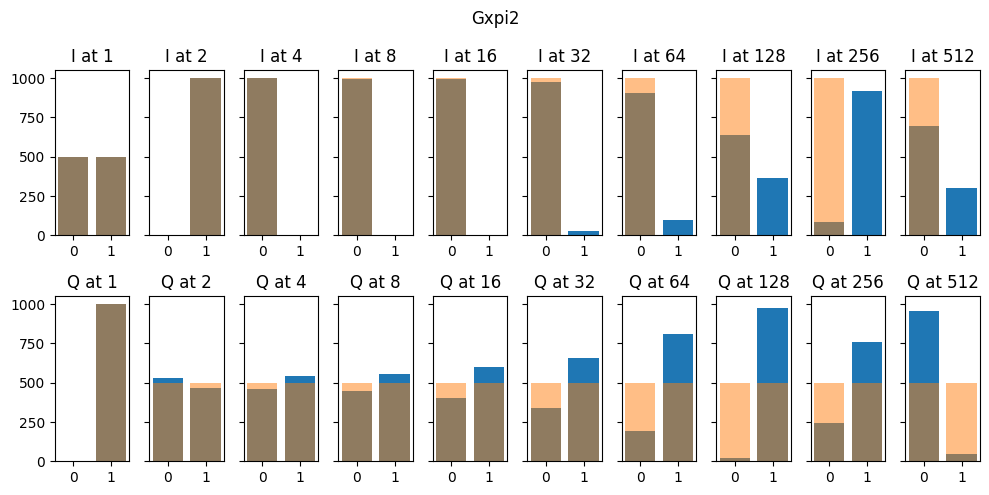

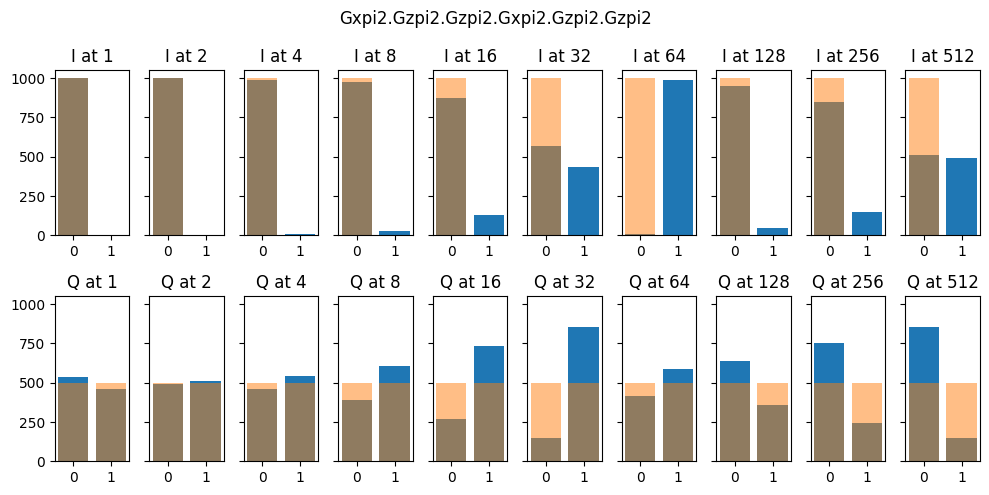

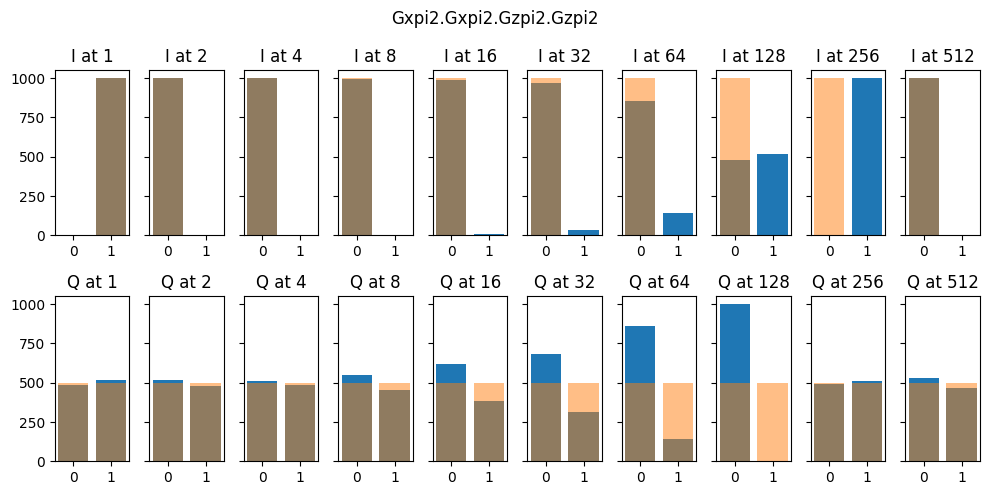

In [37]:
edesign.plot_dataset(ds, target_model)

In [18]:
def estimate_experimental_phases_1qXZ(ds, edesign):
    """
    Estimate the phases of all germs in a dataset using RPE.
    """
    depths = edesign.depths
    phase_estimates = {}
    last_good_indices = {}
    for germ in edesign.germs:
        germ_hash = edesign.germ_to_hash(germ)
        estimates, lgg = estimate_phase(ds, edesign, germ, '0', '1', '0', '1', depths)
        phase_estimates[germ_hash] = estimates[lgg]
        last_good_indices[germ_hash] = lgg
    return phase_estimates, last_good_indices

In [19]:
estimate_experimental_phases_1qXZ(ds, edesign)

({'Gxpi2': 4.702388612213497,
  'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2': 6.237115956565627,
  'Gxpi2.Gxpi2.Gzpi2.Gzpi2': 3.1539934766651987},
 {'Gxpi2': 9,
  'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2': 9,
  'Gxpi2.Gxpi2.Gzpi2.Gzpi2': 9})

In [20]:
estimate_phase(ds, edesign, germs[0], '0', '1', '0', '1', depths)

(array([4.71038898, 4.67943677, 4.69193474, 4.69888751, 4.70010013,
        4.70219574, 4.70216244, 4.70228702, 4.7022882 , 4.70238861]),
 9)

In [21]:
estimate_phase(ds, edesign, germs[1], '0', '1', '0', '1', depths)

(array([0.07386537, 6.27518599, 6.26130259, 6.25493177, 6.24860441,
        6.23994333, 6.23684354, 6.23642873, 6.23655945, 6.23711596]),
 9)

In [22]:
estimate_phase(ds, edesign, germs[2], '0', '1', '0', '1', depths)

(array([3.17557956, 3.161582  , 3.14860484, 3.1538769 , 3.15645376,
        3.15329884, 3.15388635, 3.15416123, 3.15392712, 3.15399348]),
 9)

# run on device

In [24]:
import qcal.settings as settings

from qcal.config import Config
from qcal.managers.classification_manager import ClassificationManager
from qcal.math.utils import round_to_order_error
from qcal.qpu.qpu import QPU

import logging

from collections.abc import Iterable
from IPython.display import clear_output
from numpy.typing import NDArray
from typing import Any, Callable, Dict, List, Tuple

In [25]:
import qcal as qc
import qcal.backend.qubic.transpiler as qbt
from qcal.units import *
from qcal.utils import load_from_pickle
from qcal.backend.qubic.qpu import QubicQPU

In [26]:
def RPE_Experiment_1QXZ(
        qpu:             QPU,
        config:          Config,
        qubit_label:     int,
        edesign:         ExperimentDesign,
        compiler:        Any | None = None,
        transpiler:      Any | None = None,
        classifier:      ClassificationManager = None,
        n_shots:         int = 1024,
        n_batches:       int = 1,
        n_circs_per_seq: int = 1,
        raster_circuits: bool = False,
        **kwargs
    ) -> Callable:
    """Robust Phase Estimation.

    This protocol requires a valid pyGSTi and pyRPE installation.

    Args:
        qpu (QPU): custom QPU object.
        config (Config): qcal Config object.
        qubit_labels (Iterable[int]): a list specifying sets of system labels 
            on which to perform RPE for a given gate.
        experiment (str): type of RPE experiment.
        circuit_depths (List[int]): a list of positive integers specifying the 
            circuit depths.
        compiler (Any | Compiler | None, optional): custom compiler to compile
            the True-Q circuits. Defaults to None.
        transpiler (Any | None, optional): custom transpiler to transpile
            the True-Q circuits to experimental circuits. Defaults to None.
        classifier (ClassificationManager, optional): manager used for 
            classifying raw data. Defaults to None.
        n_shots (int, optional): number of measurements per circuit. 
                Defaults to 1024.
        n_batches (int, optional): number of batches of measurements. Defaults
            to 1.
        n_circs_per_seq (int, optional): maximum number of circuits that can be
            measured per sequence. Defaults to 1.
        raster_circuits (bool, optional): whether to raster through all
            circuits in a batch during measurement. Defaults to False. By
            default, all circuits in a batch will be measured n_shots times
            one by one. If True, all circuits in a batch will be measured
            back-to-back one shot at a time. This can help average out the 
            effects of drift on the timescale of a measurement.

    Returns:
        Callable: RPE class instance.
    """

    class RPE_Experiment_1QXZ(qpu):
        """pyRPE protocol."""

        def __init__(self,
                config:          Config,
                qubit_label:     int,
                edesign:         ExperimentDesign,
                compiler:        Any | None = None,
                transpiler:      Any | None = None,
                classifier:      ClassificationManager = None,
                n_shots:         int = 1024,
                n_batches:       int = 1,
                n_circs_per_seq: int = 1,
                raster_circuits: bool = False,
                **kwargs
            ) -> None:
            from qcal.interface.pygsti.transpiler import Transpiler

            try:
                import pygsti
                from pygsti.modelpacks import smq2Q_XXYYII
                from pygsti.modelpacks import smq2Q_XYICPHASE
                logger.info(f" pyGSTi version: {pygsti.__version__}\n")
            except ImportError:
                logger.warning(' Unable to import pyGSTi!')

            self._config = config
            self._qubit_labels = [qubit_label]
            self._edesign = edesign
            self._qubits = [qubit_label]
            self._n_shots = n_shots


            self._pygsti_circuits = edesign.circuit_list

            
            
            if transpiler is None:
                transpiler = Transpiler()

            qpu.__init__(self,
                config=config, 
                compiler=compiler, 
                transpiler=transpiler,
                classifier=classifier,
                n_shots=n_shots, 
                n_batches=n_batches, 
                n_circs_per_seq=n_circs_per_seq, 
                raster_circuits=raster_circuits,
                **kwargs
            )
            self._circuits = self.generate_circuits()

        def generate_circuits(self):
            """Generate all RPE circuits."""
            from qcal.interface.pygsti.circuits import load_circuits

            logger.info(' Generating circuits from pyGSTi...')
            self._circuits = load_circuits(self._pygsti_circuits)

        def generate_pygsti_dataset(self):
            """Generate a pyGSTi dataset for each qubit label."""
            logger.info(' Generating pyGSTi reports...')
            
            circuits = self._transpiled_circuits
            fileloc = self.data_manager.save_path
            for ql in self._qubit_labels:
                if isinstance(ql, Iterable):
                    q_index = tuple([self._qubits.index(q) for q in ql])
                    qs = ''.join(str(q) for q in ql)
                else:
                    q_index = tuple([self._qubits.index(ql)])
                    qs = str(ql)

                results_dfs = []
                for i, circuit in enumerate(circuits):
                    results_dfs.append(
                        pd.DataFrame(
                            [circuit.results.marginalize(q_index).dict], 
                            index=[circuits['pygsti_circuit'][i]]
                        )
                    )
                results_df = pd.concat(results_dfs)
                results_df = results_df.fillna(0).astype(int).rename(
                    columns=lambda col: col + ' count'
                )
                self._df = results_df

                with open(f'{fileloc}dataset_{qs}.txt', 'w') as f:
                    f.write(
                        '## Columns = ' + ', '.join(results_df.columns) + "\n"
                    )
                    f.close()
                results_df.to_csv(
                    f'{fileloc}dataset_{qs}.txt', 
                    sep=' ', 
                    mode='a', 
                    header=False
                )

        def run(self):
            """Run all experimental methods and analyze results."""
            self.generate_circuits()
            qpu.run(self, self._circuits, save=False)
            self.save()
            self.generate_pygsti_dataset()
            
    return RPE_Experiment_1QXZ(
        config,
        qubit_label,
        edesign,       
        compiler,      
        transpiler,    
        classifier,    
        n_shots,       
        n_batches,     
        n_circs_per_seq,
        raster_circuits,
        **kwargs
    )

In [27]:
import qcal.settings as settings

logger = logging.getLogger(__name__)

basedir = '/home/jpmarceaux/experiment/'
settings.Settings.config_path = basedir + 'config/'
settings.Settings.data_path = basedir + 'data/'
settings.Settings.save_data = True



#cfg = qc.Config()
cfg = qc.Config(basedir + 'config/configs/X6Y3/config.yaml')
classifier = load_from_pickle(basedir + 'config/configs/X6Y3/ClassificationManager.pkl')
# cfg = qc.Config(basedir + 'config/Campbell06/X6Y3/config_abhi.yaml')
cfg.draw_qpu()

In [28]:
qid = 'Q4'
germs_exp = make_1q_xz_germs(qid)
inphase_state_prep_exp = make_1q_xz_inphase_preps(qid)
quad_state_prep_exp = make_1q_xz_quadrature_preps(qid)
meas_exp = make_1q_xz_measurment(qid)
depths_exp = [2**i for i in range(9)]
line_labels = [qid]

edesign_exp = ExperimentDesign(germs_exp, inphase_state_prep_exp, quad_state_prep_exp, meas_exp, depths_exp, line_labels)

In [29]:
germs_exp

[[('Gxpi2', 'Q4')],
 [('Gxpi2', 'Q4'),
  ('Gzpi2', 'Q4'),
  ('Gzpi2', 'Q4'),
  ('Gxpi2', 'Q4'),
  ('Gzpi2', 'Q4'),
  ('Gzpi2', 'Q4')],
 [('Gxpi2', 'Q4'), ('Gxpi2', 'Q4'), ('Gzpi2', 'Q4'), ('Gzpi2', 'Q4')]]

In [30]:
edesign_exp

In [31]:
rpe_exp = RPE_Experiment_1QXZ(QubicQPU, cfg,int(qid[1]), edesign_exp, 
    classifier=classifier,
    n_shots=512,
    n_circs_per_seq=100,
    reload_pulse=False,
    reload_freq=False,
    reload_env=False,
    zero_between_reload=False
)

INFO:__main__: pyGSTi version: 0.9.12.2

INFO:__main__: Generating circuits from pyGSTi...


In [32]:
rpe_exp.run()

INFO:QPU: Data save location: /home/jpmarceaux/experiment/data/2024-10-14/20241014_120551/

INFO:__main__: Generating pyGSTi reports...


Runtime:   Compile  Transpile  Sequencing  Write  Measure  Process  Total
Time (s)      0.0        0.1         1.0    0.0     29.0      0.1   30.2



In [33]:
ds_exp = pygsti.io.read_dataset(rpe_exp.data_manager.save_path + 'dataset_4.txt')

Reading /home/jpmarceaux/experiment/data/2024-10-14/20241014_120551/dataset_4.txt: 100%


In [34]:
estimate_experimental_phases_1qXZ(ds_exp, edesign_exp)

({'Gxpi2': 0.11959744390707057,
  'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2': 6.100541510871744,
  'Gxpi2.Gxpi2.Gzpi2.Gzpi2': 5.602107361194486},
 {'Gxpi2': 3,
  'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2': 3,
  'Gxpi2.Gxpi2.Gzpi2.Gzpi2': 1})

In [35]:
estimate_model_phases_from_experiment(ds_exp, edesign_exp)

NameError: name 'estimate_model_phases_from_experiment' is not defined

In [36]:
target_model = create_XZ_model_1q(np.array([0, 0, 0]))

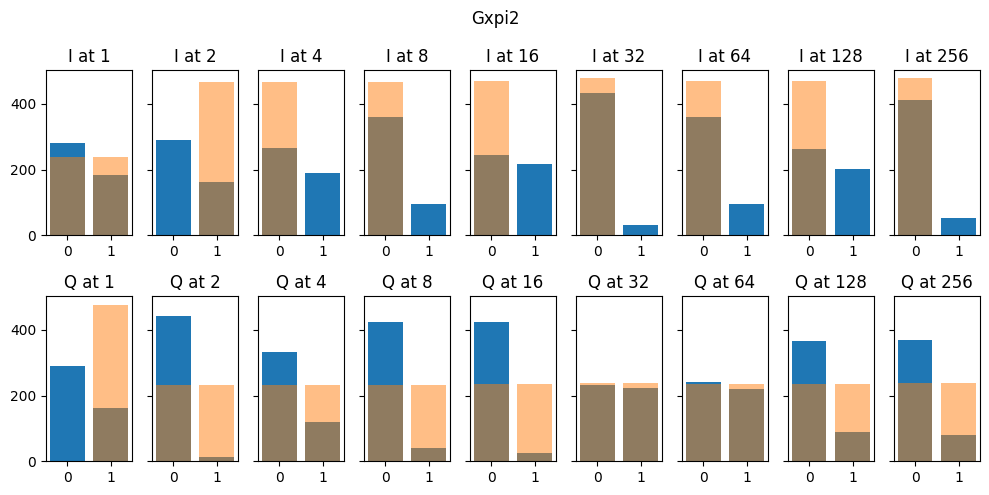

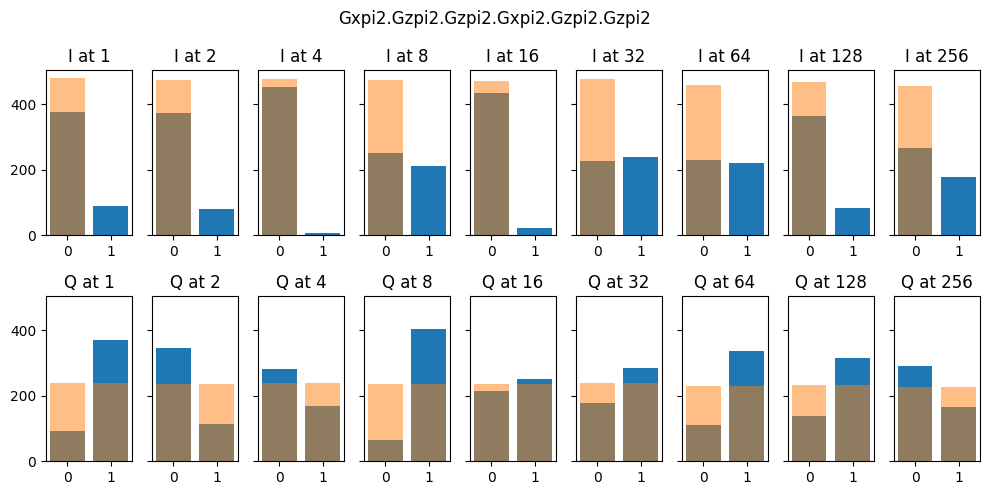

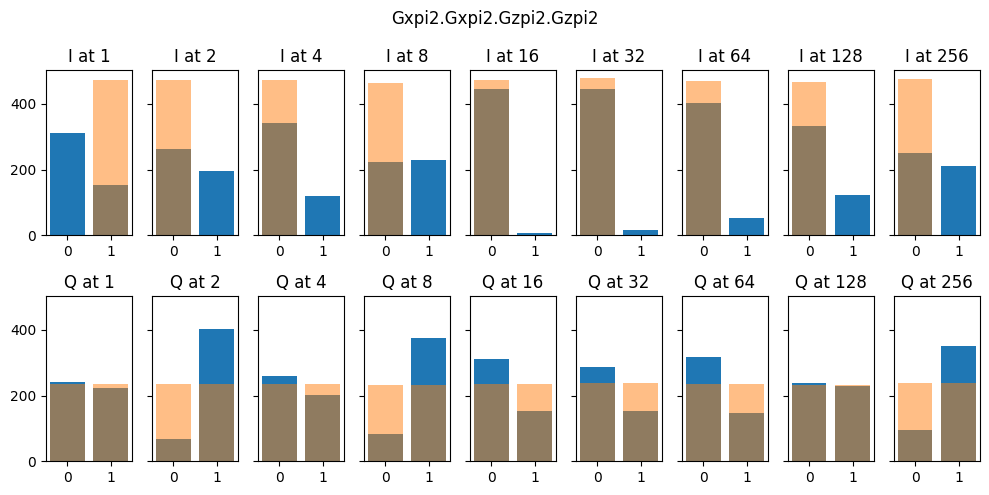

In [37]:
target_model = create_XZ_model_1q(np.array([0, 0, 0]), qid = qid)
edesign_exp.plot_dataset(ds_exp, target_model)

# Analysis

We estimate the model phases by finding the parameters that minimize the difference between the model eigenvalues and the measured eigenvalues. 

In [38]:
from qcal.modelconstruction.single_qubit_models import X90_unitary, Z90_unitary

In [40]:
def germ_to_unitary(x_vec, germ):
    """
    Convert a germ to a unitary matrix.
    """
    x_gate_x_error = x_vec[0]
    x_gate_z_error = x_vec[1]
    z_gate_z_error = x_vec[2]

    x90 = X90_unitary(x_gate_x_error, x_gate_z_error)
    z90 = Z90_unitary(z_gate_z_error)
    unitary = np.eye(2)
    for gate in germ:
        if gate[0] == 'Gxpi2':
            unitary = x90 @ unitary
        elif gate[0] == 'Gzpi2':
            unitary = z90 @ unitary
    return unitary

def calc_eigenphase_of_unitary(unitary):
    """
    Calculate the eigenphase of a unitary matrix.

    The eigenphase is i log(lambda) where lambda is the *invariant* eigenvalue of the unitary matrix
    and angle is the angle of the complex number. We assert that the modulus of both eigenvalues is 1.

    To make the eigenvalues invariant, we multiply by the complex conjugate of the first eigenvalue and take the second. 
    """
    eigvals, eigvecs = np.linalg.eig(unitary)
    eigval1 = eigvals[0]
    eigval2 = eigvals[1]
    eigval2_inv = np.conj(eigval1) * eigval2
    eigenphase = 1j * np.log(eigval2_inv)
    assert np.imag(eigenphase) < 1e-10
    return np.real(eigenphase)

def calc_phase_error(x_vec, germs, phases):
    error = 0
    for idx, germ in enumerate(germs):
        unitary = germ_to_unitary(x_vec, germ)
        eigenphase = calc_eigenphase_of_unitary(unitary)
        e = np.sin(eigenphase - phases[idx])**2
        error += e
    return error

def find_minimizing_parameters(germs, phases):
    """
    Find the parameters 

    Phase dict is a dictionary with keys that are the germs and values that are the estimated phases.
    """
    

    res = scipy.optimize.minimize(calc_phase_error, [0.0, 0.0, 0.0], args=(germs, phases,), method='Nelder-Mead')
    return res.x

def estimate_model_phases_from_experiment(dataset, edesign):
    """
    Estimate the phases of a model from an experimental dataset.
    """
    phases, lggs = estimate_experimental_phases_1qXZ(dataset, edesign)
    germ_list = edesign.germs
    phase_list = [phases[edesign.germ_to_hash(germ)] for germ in germ_list]
    return find_minimizing_parameters(germ_list, phase_list)

    

In [41]:
error_vec = np.array([0.013, 0.0436, 0.038])
zx_model = create_XZ_model_1q(error_vec)
target_model = create_XZ_model_1q(np.array([0, 0, 0]))
depths = [2**i for i in range(10)]
germs = make_1q_xz_germs('Q0')
inphase_state_prep = make_1q_xz_inphase_preps('Q0')
quad_state_prep = make_1q_xz_quadrature_preps('Q0')
meas = make_1q_xz_measurment('Q0')
line_labels = ['Q0']
edesign = ExperimentDesign(germs, inphase_state_prep, quad_state_prep, meas, depths, line_labels)
ds = pygsti.data.simulate_data(zx_model, edesign.circuit_list, num_samples=1000, seed=2021)
edesign.germs


[[('Gxpi2', 'Q0')],
 [('Gxpi2', 'Q0'),
  ('Gzpi2', 'Q0'),
  ('Gzpi2', 'Q0'),
  ('Gxpi2', 'Q0'),
  ('Gzpi2', 'Q0'),
  ('Gzpi2', 'Q0')],
 [('Gxpi2', 'Q0'), ('Gxpi2', 'Q0'), ('Gzpi2', 'Q0'), ('Gzpi2', 'Q0')]]

In [44]:
experimental_phases, lgg_dict = estimate_experimental_phases_1qXZ(ds, edesign)
experimental_phase_list = [experimental_phases[edesign.germ_to_hash(germ)] for germ in edesign.germs]
experimental_germs = [germ for germ in edesign.germs]

In [45]:
lgg_dict

{'Gxpi2': 9,
 'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2': 9,
 'Gxpi2.Gxpi2.Gzpi2.Gzpi2': 9}

In [46]:
phase0 = calc_eigenphase_of_unitary(germ_to_unitary(error_vec, germs[0]))
phase1 = calc_eigenphase_of_unitary(germ_to_unitary(error_vec, germs[1]))
phase2 = calc_eigenphase_of_unitary(germ_to_unitary(error_vec, germs[2]))
phases = [phase0, phase1, phase2]

In [47]:
experimental_phases

{'Gxpi2': 4.69877556978302,
 'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2': 6.098603522037016,
 'Gxpi2.Gxpi2.Gzpi2.Gzpi2': 3.195479128936741}

In [53]:
phases

[-1.584396340809018, -0.1850918339957979, -3.0876275097701553]

In [49]:
np.pi - 4.69

-1.5484073464102073

In [50]:
6.09- 2*np.pi

-0.19318530717958637

In [54]:
np.pi-3.08

0.061592653589793045

In [55]:
eigen_phase_error = np.sum([np.sin(a - b)**2 for a, b in zip(experimental_phase_list, phases)])
eigen_phase_error

2.665180072596521e-07

In [56]:
experimental_germs

[[('Gxpi2', 'Q0')],
 [('Gxpi2', 'Q0'),
  ('Gzpi2', 'Q0'),
  ('Gzpi2', 'Q0'),
  ('Gxpi2', 'Q0'),
  ('Gzpi2', 'Q0'),
  ('Gzpi2', 'Q0')],
 [('Gxpi2', 'Q0'), ('Gxpi2', 'Q0'), ('Gzpi2', 'Q0'), ('Gzpi2', 'Q0')]]

In [57]:
x = np.array([0, 0, 0])
calc_phase_error(error_vec, experimental_germs, experimental_phase_list)

2.665180072596521e-07

In [58]:
find_minimizing_parameters(experimental_germs, experimental_phase_list)

array([-7.74306683e-05,  1.88753518e-03,  6.40789412e-02])

In [59]:
error_vec

array([0.013 , 0.0436, 0.038 ])